# CNN autoencoder: training and visualization

## 0. Imports

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

## 1. What are our images

Image 64 x 64 shows a square covering coordinates (-1, 1) x (-1, 1)  
with a circle of radius "r" centered at (xc, yc)

### 1.a) Pixels (fixed once and forever):

In [2]:
pix = 64

x_edges = jnp.linspace(-1, 1, pix + 1)
x_middles = (x_edges[1:] + x_edges[:-1]) / 2

y_middles = x_middles

xx, yy = jnp.meshgrid(x_middles, y_middles)

### 1.b) Drawing circles:

In [3]:
def draw_circle(r, xc, yc):
    where_circle = (xx - xc)**2 + (yy - yc)**2 <= r**2
    cc = where_circle.astype(float)
    return cc

In [4]:
cc = draw_circle(0.7, 0.2, 0.5)

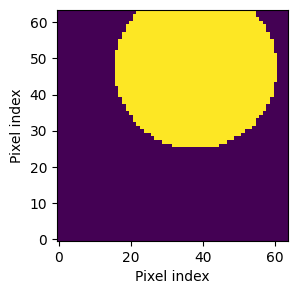

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cc);
plt.gca().invert_yaxis();
ax.set_xlabel("Pixel index");
ax.set_ylabel("Pixel index");

## 2. Data generation

1 batch = 32 images  
with circles of random radius (between 0 and 1)  
and with canters placed randomly in the square

### 2.a) Batch creation:

In [6]:
draw_circles = jax.vmap(draw_circle)

In [7]:
def create_data_batch(key, batch_size=32):

    key, subkey = jax.random.split(key)
    xc = jax.random.uniform(subkey, shape=(batch_size,), minval=-1.0, maxval=1.0)

    key, subkey = jax.random.split(key)
    yc = jax.random.uniform(subkey, shape=(batch_size,), minval=-1.0, maxval=1.0)

    key, subkey = jax.random.split(key)
    r = jax.random.uniform(subkey, shape=(batch_size,), minval=0.0, maxval=1.0)

    return draw_circles(r, xc, yc)

In [8]:
key = jax.random.key(seed=1234)
key, subkey = jax.random.split(key)

data_batch = create_data_batch(subkey)

### 2.b) Batch visualization

In [9]:
def plot_images(data_batch, label, how_many=5):
    print(f">>> {label}:")

    fig, axes = plt.subplots(1, how_many, sharey=True, subplot_kw=dict(box_aspect=1))

    for ax, cc in zip(axes, data_batch):
        im = ax.imshow(cc);
        ax.set_xticks([]);
        ax.set_yticks([]);

    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.01, pad=0.04);

    plt.gca().invert_yaxis();

>>> Batch example:


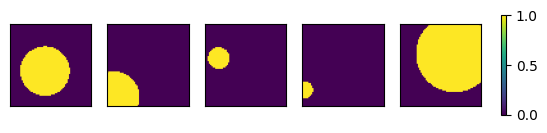

In [10]:
plot_images(data_batch, "Batch example")

### 2.c) Pack into a generator:

In [11]:
def make_batch_generator(key):
    while True:
        key, subkey = jax.random.split(key)
        data_batch = create_data_batch(subkey)
        data_batch = data_batch[..., jnp.newaxis]
        yield data_batch

In [12]:
key = jax.random.key(seed=1234)
batch_generator = make_batch_generator(key)

>>> Batch example:


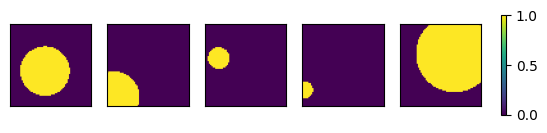

In [13]:
data_batch = next(batch_generator)

plot_images(data_batch, "Batch example")

## 3. Conv. autoencoder

### 3.a) Setup the autoencoder with flax

In [14]:
import flax.linen as nn
import optax
from flax.training.train_state import TrainState

In [15]:
def up_sample_2d(x, factors):
    new_shape = list(x.shape)

    new_shape[-3] *= factors[0]
    new_shape[-2] *= factors[1]

    x = jax.image.resize(x, shape=new_shape, method='bilinear')

    return x

In [16]:
class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        x = nn.pooling.avg_pool(x, (4, 4), strides=(4, 4))

        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        x = nn.pooling.avg_pool(x, (2, 2), strides=(2, 2))

        x = nn.Conv(1, (3, 3), padding='same')(x)
        x = nn.sigmoid(x)

        return x
    
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = up_sample_2d(x, (2, 2))
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)

        x = up_sample_2d(x, (4, 4))
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)

        x = nn.Conv(1, (3, 3), padding='same')(x)

        return x

class ConvAutoenc(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = Encoder()(x)
        x = Decoder()(x)
        return x

conv_autoenc = ConvAutoenc()
encoder = Encoder()

### 3b Initialize the parameters of the Autoencoder

In [17]:
dummy_input = jnp.ones(shape=(pix, pix, 1))

key, subkey = jax.random.split(key)
params = conv_autoenc.init(subkey, dummy_input)["params"]

In [18]:
table = conv_autoenc.tabulate(jax.random.key(0), dummy_input, column_kwargs=dict(overflow="fold"))
print(table)


                              ConvAutoenc Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module      ┃ inputs        ┃ outputs        ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ ConvAutoenc │ float32[64,64 │ float32[64,64, │               │
│               │             │ ,1]           │ 1]             │               │
├───────────────┼─────────────┼───────────────┼────────────────┼───────────────┤
│ Encoder_0     │ Encoder     │ float32[64,64 │ float32[8,8,1] │               │
│               │             │ ,1]           │                │               │
├───────────────┼─────────────┼───────────────┼────────────────┼───────────────┤
│ Encoder_0/Con │ Conv        │ float32[64,64 │ float32[64,64, │ bias:         │
│ v_0           │             │ ,1]           │ 4]             │ float32[4]    │
│               │          

### 3c Initialize the optimizer and the training state, and the define the training function

In [19]:
optimizer = optax.adam(learning_rate=0.005)

In [20]:
state = TrainState.create(apply_fn=conv_autoenc.apply, params=params, tx=optimizer)

In [21]:
@jax.jit
def train_on_batch(state, X):

    def loss_fn(params):
        # evaluate autoencoder for input X
        y_pred = state.apply_fn({'params': params}, X) 
        # calculate mean squared deviation between output and X
        sq_dev = (y_pred - X)**2  
        mean_sq_dev = sq_dev.mean()
        return mean_sq_dev

    val_and_grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = val_and_grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

### 3.d) Training

In [22]:
losses = []

In [23]:
for i in range(2000):

    X = next(batch_generator)
    y_true = X

    loss, state = train_on_batch(state, X)

    losses.append(loss)

    if (i + 1) % 100 == 0:
        print(f"Batch: {i + 1}\tloss = {loss:.3e}")

Batch: 100	loss = 2.677e-02
Batch: 200	loss = 1.883e-02
Batch: 300	loss = 1.157e-02
Batch: 400	loss = 1.102e-02
Batch: 500	loss = 9.089e-03
Batch: 600	loss = 8.417e-03
Batch: 700	loss = 6.541e-03
Batch: 800	loss = 7.731e-03
Batch: 900	loss = 5.775e-03
Batch: 1000	loss = 5.605e-03
Batch: 1100	loss = 5.470e-03
Batch: 1200	loss = 5.731e-03
Batch: 1300	loss = 4.667e-03
Batch: 1400	loss = 4.056e-03
Batch: 1500	loss = 4.574e-03
Batch: 1600	loss = 4.099e-03
Batch: 1700	loss = 4.470e-03
Batch: 1800	loss = 4.275e-03
Batch: 1900	loss = 3.462e-03
Batch: 2000	loss = 4.135e-03


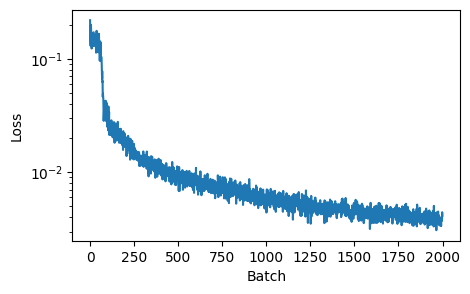

In [24]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(losses);
ax.set_yscale("log");

ax.set_xlabel("Batch");
ax.set_ylabel("Loss");

### 3.e) Visualization of reproduced images

In [25]:
def predict_on_batch(state, X):
    return state.apply_fn({'params': state.params}, X)

In [26]:
X = next(batch_generator)
y_true = X

y_predicted = predict_on_batch(state, X)

>>> True images:


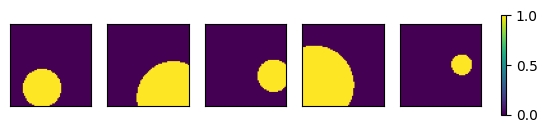

In [27]:
plot_images(y_true, "True images")

>>> Predicted images (trained):


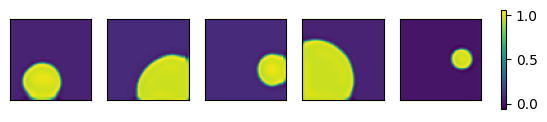

In [28]:
plot_images(y_predicted, "Predicted images (trained)")

### 5.d) Visualization of encoded images

In [29]:
params_enc = state.params['Encoder_0']

In [30]:
encoded_img = encoder.apply({'params': params_enc}, X)

>>> Encoded images:


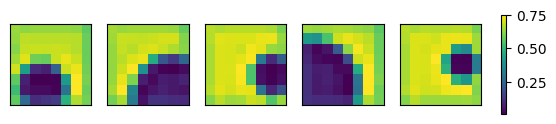

In [32]:
plot_images(encoded_img, "Encoded images")